 # FIT5202 -Assessment 2

 <font color='light blue'>
 Name-Meghna Khanna <br>
 Student_ID-29592445<br>
 Unit Information- FIT5202 Assignment 2

## Prediction Of Rain Tomorrow

### A. Creating Spark Session and Loading the Data

**Import required libraries** 

In [55]:
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, when, count, col,avg
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
import matplotlib.pyplot as plt
import numpy as np


#### Step 01: Import Spark Session and initialize Spark

## SparkContext and SparkSession
We will use and import **`SparkContext`** from **`pyspark`**, which was the main entry point for Spark Core functionality prior Spark 2.0 but now **`SparkSession`** provides a single point of entry to interact with underlying Spark functionality and allows programming Spark with DataFrame and Dataset APIs.
A [DataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) is equivalent to a relational table in Spark SQL, and can be created using various functions in SparkSession. Once created, it can be manipulated using the various domain-specific-language (DSL) functions defined in: [DataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame), [Column](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column).


In [56]:
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[4]: run Spark locally with 4 working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[4]`). 
# If we want Spark to run locally with 4 worker threads, we can specify as `local[4]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[4]", appName="Rain predictions in Australia")
spark = SparkSession(sparkContext=sc)

#### Step 02: Load the dataset and print the schema and total number of entries

In [57]:
## The parameters that are used while loading the dataset are inferSchema which
## is to infer the original features of the dataset and load the dataset 
## with it soriginal headers and as we are specifiying that the nullValues are
## represented as NA in this dataset it identifies the actual datatypes of the
## column values but if that parameter is removed it identifies all the columns with
## nullvalues as string as NA is a string value and the function cannot identify
## the nullvalues as NA, hence we used the nullValue paramter, to make it 
## easier in data transformation steps.

df = spark.read.csv("weatherAUS.csv", inferSchema=True, header=True,nullValue='NA')

In [4]:
df.dtypes

[('Date', 'timestamp'),
 ('Location', 'string'),
 ('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('Evaporation', 'double'),
 ('Sunshine', 'double'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'int'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'int'),
 ('WindSpeed3pm', 'int'),
 ('Humidity9am', 'int'),
 ('Humidity3pm', 'int'),
 ('Pressure9am', 'double'),
 ('Pressure3pm', 'double'),
 ('Cloud9am', 'int'),
 ('Cloud3pm', 'int'),
 ('Temp9am', 'double'),
 ('Temp3pm', 'double'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string')]

In [5]:
df.show(n=5, truncate=False)  # Displays the top 5 rows of the weather datasset
df.columns  # Displays all the column names 

+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date               |Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01 00:00:00|Albury  |13.4   |22.9   |0.6     |null       |null    |W          |44           |W         |WNW       |20          |24          |71         |22         |1007.7     |1007.1     |8       |null    |16.9   |21.8   |

['Date',
 'Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow']

### Information of the dataset
- `Date` - timestamp of a certain day with certain weather conditions
- `Location` - location of the weather report.
- `MinTemp` - Mininum Temperature on that specific date .
- `MaxTemp` - Maximum Temperature on that specific date.
- `Rainfall` - Amount of rainfall on that specific date in mm.
- `Evaporation` - Evaporation on that specific date.
- `Sunshine` - How bright was the sun on that specific date. 
- `WindGustDir` - Wind direction on that specific date.
- `WindDir9am` - Wind Direction at 9 am.
- `WindDir3pm` - Wind Direction at 3 pm.
- `WindSpeed9am` - Wind Direction at 9 am.
- `WindSpeed3pm` - Speed of wind at 3 pm.
- `Humidity9am` - Humidity at 9 am.
- `Humidity3pm` - Humidity at 3 pm.
- `Pressure9am` - Wind pressure at 9 am.
- `Pressure3pm` - Wind Pressure at 3pm.
- `Cloud9am` - Amount of clouds at 9 am.
- `Cloud3pm` - Amount of clouds at 3 pm.
- `Temp9am` - Temperature at 9 am.
- `Temp3pm` - Temperature at 3pm.
- `RainToday` - Categorical variable displaying if it rained today as a Yes/No.
- `RainTomorrow` - Categorical variable that displays if it rained tomorrow in form of a 
Yes/No.

##### Print the total number of entries in the dataset

In [6]:
# The number of records or rows in dataframe

print("The number of records in the weather dataset are:", df.count())

The number of records in the weather dataset are: 142193


### B. Data Cleaning and Processing

#### Step 03: Delete columns from the dataset

In [7]:
# Created a list of columns that were needed to be dropped as they were not
# of any importance and were not valuable features for our classification models 
drop_list = ['Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm',\
             'Temp9am','Temp3pm']


data = df.select([column for column in df.columns if column not in drop_list])


In [8]:
#display the dataframe after having deleted the unwanted columns
data.show(truncate=False) 

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|13.4   |22.9   |0.6     |W          |44           |W         |WNW       |20          |24          |71         |22         |1007.7     |1007.1     |No       |No          |
|7.4    |25.1   |0.0     |WNW        |44           |NNW       |WSW       |4           |22          |44         |25         |1010.6     |1007.8     |No       |No          |
|12.9   |25.7   |0.0     |WSW        |46           |W         |WSW       |19          |26          |38         |30         |1007.6     |1008

In [9]:
cols=data.columns

#### Step 04: Print the number of missing data in each column.

In [10]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show(vertical=True)

-RECORD 0--------------
 MinTemp       | 637   
 MaxTemp       | 322   
 Rainfall      | 1406  
 WindGustDir   | 9330  
 WindGustSpeed | 9270  
 WindDir9am    | 10013 
 WindDir3pm    | 3778  
 WindSpeed9am  | 1348  
 WindSpeed3pm  | 2630  
 Humidity9am   | 1774  
 Humidity3pm   | 3610  
 Pressure9am   | 14014 
 Pressure3pm   | 13981 
 RainToday     | 1406  
 RainTomorrow  | 0     



As we can see the only column that has no null values is the target variable or the variable that is to be predicted using the other variables as features or predictors and  they have many missing values and they need to be either removed or replaced with the most appropraite/approximate values to the oringinal values as it is assumed they are missing completely at random(MCAR).

#### Step 05: Fill the missing data with average value and maximum occurrence value.

#### The aim of this step is remove any Null values/missing data that is assumed missing to be missing completely at random(MCAR). <br>
`Firstly, we identify the columns which have numeric values (e.g., MinTemp, MaxTemp),
calculate the average and fill the null value with the average.We already have displayed the datatypesof the dataset that is loaded for preprocessing and as we specified nullvalue as NA all the columns are read as their original schema attributes and the numerical columns are the columns which have either integer or double datatypes that are:`
* MinTemp,
* MaxTemp,
* Rainfall,
* WindGustSpeed,
* WindSpeed9am,
* WindSpeed3pm,
* Humidity9am,
* Humidity3pm,
* Pressure9am,
* Pressure3pm,


`Secondly, we identify the columns with non-numeric values (e.g., WindGustDir, WindDir9am)and find the ​ most ​ frequent item (e.g., wind direction). Now fill the null values with that item for that particular column.We already know that the columns that have string datatype are te categorical values/non-numerical values.They are :`
* WindGustDir,
* WindDir9am,
* WindDir3pm,
* RainToday,
* RainTomorrow.

In [11]:
## Here x is the column and t is the datatype so we impute the string columns
## with maximum occuring value in that column basically value with highest frequency
## so for that imputation we groupby the colums and then orderby the frequencies/
## count in descending order and take the first value in that dataframe,
## and then using na.fill to fill that frequency to that column;
## Similarly for non-string columns the average is rounded and imputed to the
## non-numeric columns with null values.

for x, t in data.dtypes:
    if t=="string":
            i=data.groupby(x).count().orderBy('count',ascending=False).first()[0]
            data=data.na.fill({x: i})
    else:
        average=data.select(x).agg(avg(x)).first()[0], [x]
        rounded_avg=round(average[0],1)
        data=data.na.fill({x: rounded_avg})
        

In [12]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show(vertical=True)

-RECORD 0------------
 MinTemp       | 0   
 MaxTemp       | 0   
 Rainfall      | 0   
 WindGustDir   | 0   
 WindGustSpeed | 0   
 WindDir9am    | 0   
 WindDir3pm    | 0   
 WindSpeed9am  | 0   
 WindSpeed3pm  | 0   
 Humidity9am   | 0   
 Humidity3pm   | 0   
 Pressure9am   | 0   
 Pressure3pm   | 0   
 RainToday     | 0   
 RainTomorrow  | 0   



As we can see the values have been successfully imputed and no null values remain.

### Step 06: Data transformation

Here the aim of this step is to perform the following tasks: <br>
* ` type cast the numerical value columns to double;`
* ` For the non-numerical value column (i.e., WindGustDir,WindDir9am, WindDir3pm, RainTomorrow) use the StringIndexer method to convert them into numbers.`

In [13]:
# converting the integer columns to double type
for x,t in data.dtypes:
    if t !="string":
        data=data.withColumn(x, data[x].cast("Double"))


In [14]:
data.printSchema() 
# the numeric columns are of double data type , the integer columns 
# also got converted to double

root
 |-- MinTemp: double (nullable = false)
 |-- MaxTemp: double (nullable = false)
 |-- Rainfall: double (nullable = false)
 |-- WindGustDir: string (nullable = false)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = false)
 |-- WindDir3pm: string (nullable = false)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = false)
 |-- Pressure3pm: double (nullable = false)
 |-- RainToday: string (nullable = false)
 |-- RainTomorrow: string (nullable = false)



In [15]:
# Here, we write a code to create two separate lists for categorical columns and 
## numerial columns as it will be easier to perform transformations as the 
## transformations would be different for categorical columns and 
## numerical columns.

categoricalcols=[]
numericCols=[]
for x,t in data.dtypes:
    if t == "string":
        categoricalcols.append(x)
    else:
        numericCols.append(x)

In [16]:
## These are the categorical columns with Rain Tomorrow being the target variable
## store all variables except the target variable, since it is a binary class
## column we will only do String Indexing on it and since the other features are
## muliclass and not ordinal we perform One-Hot Encoding too, as one hot encoding 
## needs continuous variables not discrete, one hot discretizes the features. 
categoricalColumns = categoricalcols[:-1]
categoricalColumns

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [17]:
numericCols  # view of the numeric columns

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm']

#### Indexing the category list in two stages

In [18]:
stages=[]
for categoricalCol in categoricalColumns:
    # Assigning a numeric index value to each category
    # Why do you do this: to sequence between categories
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    
    
    #Convert indexed categories to one-hot encoded variables (classVec)
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    #When printing steps, a binary vector is added to the end of each line.
    stages += [stringIndexer, encoder]

*The reason we performed string indexing and one hot encoding on the categorical columns
is that string indexing assigns 0 to the most frequent value , then 1 to second frequent which is a problem with label encoding as it assumes that higher the categorical value, better the category, and that makes the model biased and would give a bad test accuracy that is why we use one hot encoder to perform “binarization” of the category and include it as a feature to train the model.*

#### Encode the label value into label_stringIdx

*String index the target value we do not need to perform one_hot encoding on it just string indexing since it has 2 classes.*

In [19]:
##  Here we string index the target variable that is Rain Tomorrow and string 
## imdexing is then applied to all the values of Rain Tomorrow for each record.


label_stringIdx = StringIndexer(inputCol = 'RainTomorrow', outputCol = 'label')
stages += [label_stringIdx]
## Here all the features which are now one hot encoded and string indexed and 
## are now ready to be passed to the vector assembler
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

### Step 07: Create the feature vector and divide the dataset

#### Bind all feature columns

In [20]:
## Here all the features with classVec in the column name are combined
## to one vector whcih will be stored in the features column 

assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")
## stages basically consists of the pipeline stages that is basically first
## string indexing then one hot encoding
stages += [assembler]


In [21]:
## It is the pipeline applied to the categorical features which we have 5 of
stages

[StringIndexer_e946db91640b,
 OneHotEncoderEstimator_237a0507a622,
 StringIndexer_8f03b63701b1,
 OneHotEncoderEstimator_1903ccac5015,
 StringIndexer_5ebd8efc3d3d,
 OneHotEncoderEstimator_97912d11bd36,
 StringIndexer_d856ff0bc463,
 OneHotEncoderEstimator_685adb99b219,
 StringIndexer_e93469d60823,
 VectorAssembler_088082d87b5c]

#### Apply the pipeline of string indexing and one_hot ending to all the feature variables 

In [22]:
## Here the stages of the pipeline which was stored in stages will now be passed
## to Pipeline which will create a pipeline with the these stages.

pipeline = Pipeline(stages = stages)
##Here the pipeline is now fit to the original dataframe .
pipelineModel = pipeline.fit(data)
## Here the pipeline is then applied to the weather dataframe and the dataframe is
## then transformed in terms of the pipeline .
data = pipelineModel.transform(data)

In [23]:
## This is the glimpse of the transformed weather dataframe with two new columns that
## are label and features where label is the target variable which is string indexed
## and the features column which is a vector of all the feature values, the vector
## has 3 components first is the size of the sparse vector, second is where the
## vector is populated and the third are the feature values for each record.

data.show(n=10,truncate=False,vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------
 MinTemp             | 13.4                                                                                                                   
 MaxTemp             | 22.9                                                                                                                   
 Rainfall            | 0.6                                                                                                                    
 WindGustDir         | W                                                                                                                      
 WindGustSpeed       | 44.0                                                                                                                   
 WindDir9am          | W                                                                                                                      

In [24]:
## Choose only label and features to create a dataframe along with the original data
## data columns thus removing the vector representations for each feature separately. 
selectedCols = ['label','features'] + cols
#selectedCols
data = data.select(selectedCols)
## final dataframe that is going to be used for training the model.
data.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- MinTemp: double (nullable = false)
 |-- MaxTemp: double (nullable = false)
 |-- Rainfall: double (nullable = false)
 |-- WindGustDir: string (nullable = false)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = false)
 |-- WindDir3pm: string (nullable = false)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = false)
 |-- Pressure3pm: double (nullable = false)
 |-- RainToday: string (nullable = false)
 |-- RainTomorrow: string (nullable = false)



### Train Test Split

**We split the data into training and testing data, and we do a random split to provide an unbiased evaluation of a model fit on the training dataset**. 

In [25]:
## Here the seed is ser to 6969 but it can be set to any number and seed is used to
## randomly split the data into train and test data from the same distributions 
## so basically both train and test data indices are of normal distribution and
## unbiased. We perform a 70-30 split where train=70% of data and test=30% of data

train, test = data.randomSplit([0.7, 0.3], seed = 6969)
print("Training Dataset Count: " + str(train.count())) # size of training data
print("Test Dataset Count: " + str(test.count())) # size of testing data

Training Dataset Count: 99765
Test Dataset Count: 42428


### C: Apply Machine Learning Algorithms

## Logistic Regression()

In statistics, the logistic model/logit model is used to model the probability of a certain class or event occuring/taking place such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether it will Rain tomorrow or not in this classification problem. Each value in the weather data would be assigned a probability between 0 and 1,i.e. the probability of that event happening and the sum always adds to 1 as the probability of an event happening can never be greater than 100%.

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable. In regression analysis, logistic regression/logit regression is estimating the parameters of a logistic model.

In [26]:
## Here we are training the model with the features present in the features column.
## LogisticRegression takes the features column predicts the labels for each 
## record then this predicted labels are fit to the train dataset.

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [27]:
## The trained model that is lr_model is then applied to the test data.
## transform() takes unseen data that is test data and predicts the labels 
## for test data based on what it learned from the train data.

predictions_lr = lrModel.transform(test)

In [28]:
## This is a dataframe which contains the missclassification and rightly
## classified labels basically the true positives and negatives and false
## positives and negatives.

predictions_logistic=predictions_lr.groupBy('label', 'prediction').count()

## Confusion Matrix for Logistic Regression

In [29]:
## It seemed better to display the confusion matrix along with model implemetation so 
## displayed the confusion matrix here.

predictions_logistic.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 3848|
|  0.0|       1.0| 2056|
|  1.0|       0.0| 5714|
|  0.0|       0.0|30810|
+-----+----------+-----+



In [30]:
## We use multiclassifcation evaluator to evaluate the accuracy of the predicted labels
## for the test set using the label and prediction column using the count of
## falsely and rightly classified data,we use Multiclass evaluator even though it
## is Binary Classification as multiclass is used for 2 or above classes,so
## it gives the same accuracy as Binary evaluator so we can use either.
## compute accuracy on the test set

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

## apply the evaluator to the predicted values

accuracy_logistic= evaluator.evaluate(predictions_lr)


In [31]:
print("The accuracy for the Logistic Regression Model is:",accuracy_logistic * 100,"%")

The accuracy for the Logistic Regression Model is: 81.6866220420477 %


### DecisionTreeClassifier()

*Decision tree learning uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.*
<br>
<br>
*It calculates information gain on every junction of the branch based on the entropy of each element and makes a decision and keeps on doing that till it reaches the leaves which are the class labels.*


In [32]:
## Here we are training the model with the features present in the features column.
## DecisionTreeClassifier takes the features column predicts the labels for each 
## record then this predicted labels are fit to the train dataset.


dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(train)

## The trained model that is dt_model is then applied to the test data.
## transform() takes unseen data that is test data and predicts the labels 
## for test data based on what it learned from the train data.


predictions = dt_model.transform(test)

## This is a dataframe which contains the missclassification and rightly
## classified labels basically the true positives and negatives and false
## positives and negatives.

predictions_tree=predictions.groupBy("label","prediction").count()


## Confusion Matrix for Decision Tree Classifer

In [33]:
## It seemed better to display the confusion matrix along with model implemetation so 
## displayed the confusion matrix here.

predictions_tree.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 3598|
|  0.0|       1.0| 1114|
|  1.0|       0.0| 5964|
|  0.0|       0.0|31752|
+-----+----------+-----+



In [34]:
## We use Multiclassifcation evaluator to evaluate the accuracy of the predicted labels
## for the test set using the label and prediction column using the count of
## falsely and rightly classified data,we use Multiclass evaluator even though it
## is Binary Classification as multiclass is used for 2 or above classes,so
## it gives the same accuracy as Binary evaluator so we can use either.


evaluator = MulticlassClassificationEvaluator(\

labelCol="label", predictionCol="prediction",\

metricName="accuracy")
  
## apply the evaluator to calculate the accuracy .  
    
accuracy = evaluator.evaluate(predictions)


In [35]:
print("The accuracy for the Decision Tree Classifier is:",accuracy * 100,"%")

The accuracy for the Decision Tree Classifier is: 83.31762043933252 %


### RandomForestClassifier()

**Random forests** or **random decision forests** are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.<br>

The difference between decsion tree and random forest is that decision tree illustrates every at each branch and random forest illustrates only the final outcome from all the branches.

In [36]:
## Here we are training the model with the features present in the features column.
## RandomForestClassifier takes the features column predicts the labels for each 
## record then this predicted labels are fit to the train dataset.

rf = RandomForestClassifier(labelCol="label",\
featuresCol="features", numTrees=10)

rf_model = rf.fit(train)

## The trained model that is rf_model is then applied to the test data.
## transform() takes unseen data that is test data and predicts the labels 
## for test data based on what it learned from the train data.

predictions_rf = rf_model.transform(test)

## This is a dataframe which contains the missclassification and rightly
## classified labels basically the true positives and negatives and false
## positives and negatives.

predictions_random_forest=predictions_rf.groupBy("label","prediction").count()



## Confusion Matrix for Random Forest Classifier

In [37]:
## It seemed better to display the confusion matrix along with model implemetation so 
## displayed the confusion matrix here.

predictions_random_forest.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2612|
|  0.0|       1.0|  610|
|  1.0|       0.0| 6950|
|  0.0|       0.0|32256|
+-----+----------+-----+



In [38]:
## We use multiclassifcation evaluator to evaluate the accuracy of the predicted labels
## for the test set using the label and prediction column using the count of
## falsely and rightly classified data, we use Multiclass evaluator even though it
## is Binary Classification as multiclass is used for 2 or above classes,so
## it gives the same accuracy as Binary evaluator so we can use either.

evaluator =\
MulticlassClassificationEvaluator(labelCol="label",\
predictionCol="prediction", metricName="accuracy")

## apply the evaluator to the predictions to calculate accuracy.

accuracy_rf = evaluator.evaluate(predictions_rf)


In [39]:
print("The accuracy for the Random Forest Classifier Model is:",accuracy_rf * 100,"%")

The accuracy for the Random Forest Classifier Model is: 82.18157820307344 %


### Gradient Boost Classifier()

*Boosting* means combining simple and weak learners to create more accurate and powerful ones. Even if the accuracy is low, once the model is created, the weaknesses (forecasting errors) are complemented by the second model. 


In [40]:
## Here we are training the model with the features present in the features column.
## GBTClassifier takes the features column predicts the labels for each 
## record then this predicted labels are fit to the train dataset.

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)

## The trained model that is gbtModel is then applied to the test data.
## transform() takes unseen data that is test data and predicts the labels 
## for test data based on what it learned from the train data.

predictions_gbt = gbtModel.transform(test)

## This is a dataframe which contains the missclassification and rightly
## classified labels basically the true positives and negatives and false
## positives and negatives.

predictions_gradient=predictions_gbt.groupBy("label","prediction").count()

## Confusion Matrix for Gradient Boost Classifier

In [41]:
## It seemed better to display the confusion matrix along with model implemetation so 
## displayed the confusion matrix here

predictions_gradient.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 4171|
|  0.0|       1.0| 1420|
|  1.0|       0.0| 5391|
|  0.0|       0.0|31446|
+-----+----------+-----+



In [42]:
## We use multiclassifcation evaluator to evaluate the accuracy of the predicted labels
## for the test set using the label and prediction column using the count of
## falsely and rightly classified data, we use Multiclass evaluator even though it
## is Binary Classification as multiclass is used for 2 or above classes,so
## it gives the same accuracy as Binary evaluator so we can use either.

evaluator =MulticlassClassificationEvaluator(labelCol="label",\
predictionCol="prediction", metricName="accuracy")

## Apply the evaluator to calculate accuracy. 

accuracy_gbt = evaluator.evaluate(predictions_gbt)


In [43]:
print("The accuracy for the Random Forest Classifier Model is:",accuracy_gbt * 100,"%")

The accuracy for the Random Forest Classifier Model is: 83.94692184406523 %


#### Model Comparision

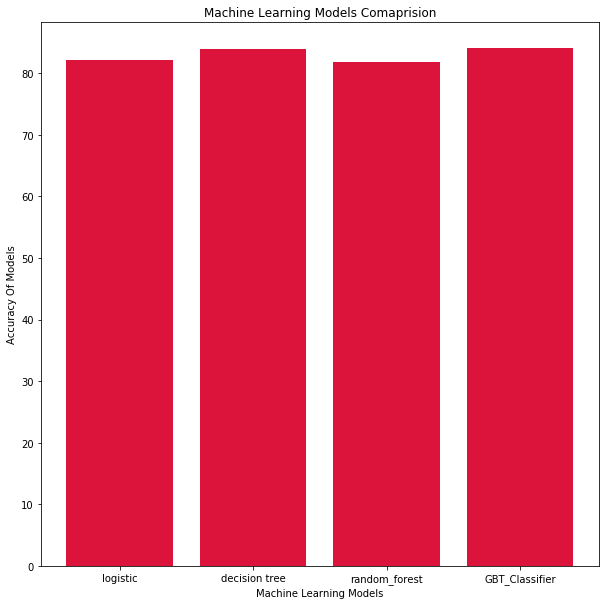

In [44]:
plt.figure(figsize=(10,10))
font = {'weight' : 'bold',
        'size'   : 15}
models = ('logistic', 'decision tree', 'random_forest', 'GBT_Classifier')
x_pos=np.arange(len(models))
accuracies = [82.0502,83.8442,81.8122,84.05]

plt.bar(x_pos, accuracies, align='center', color='#DC143C')

plt.xticks(x_pos, models)
plt.xlabel('Machine Learning Models')
plt.ylabel('Accuracy Of Models')
plt.title('Machine Learning Models Comaprision')

plt.rc('font', **font)

plt.show()

**The accuracy is almost the same for all the models with Gradient Boost Classifier giving the highest accuracy as it uses a boosted algorithm so it is higher by 1% and the lowest being Random Forest. These models can predict it can rain tomorrow with 83% or 84% confidence basically if the probability of a record for it raining tomorrow is 50% or greater the predicted label is Yes otherwise No. So basically accuracy means that the model predicts right 83/84% of the times.**

### Step 09: Find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved? These metrics are calculated for Rain Tomorrow(Target variable)=='Yes'(Label') 

`True Positive:` Postive values that were predicted as Positives ,<br>
`True Negative:` Negative values that were predicted as Negatives ,<br>
`False Positive:` Positive values that were predicted as Negative ,<br>
`False Negative:` Negative values that were predicted as Positive ,<br>

$$Precision = \frac{True Postive}{True Positive + True negative}$$
<br>
$$ = \frac{True Positive}{Total Predicted Positive}$$ <br>

`Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive.It is a good measure to determine when the costs of False Positive are high that means values that are actually positive but classified as negative.`

$$Recall = \frac{True Positive}{True Positive + False Positive}$$ <br>
$$ = \frac{True Positive}{Total Actual Positive}$$ <br>


`Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive).It is a good metric when the cost is high associated with False Negative.`

$$ F1\ Score  = 2 \times \frac{precision \times recall}{precision + recall}$$
<br>
`Is a good metric when we want an even class distribution or a way to seek good balance of true negatives and true positives as the accuracy is mostly attributed by classifying true negatives more than true positives.`

In [45]:
## Here we defined a function called conf_matrix which first identifies the count of true positives
## and negatives and false positives and negatives and then calculated the
## accuracy metrics using the formulae for those metrics.


def conf_matrix(predictions_data):
    tp = predictions_data[(predictions_data.label == 1) & (predictions_data.prediction == 1)].count()
    tn = predictions_data[(predictions_data.label == 0) & (predictions_data.prediction == 0)].count()
    fp = predictions_data[(predictions_data.label == 0) & (predictions_data.prediction == 1)].count()
    fn = predictions_data[(predictions_data.label == 1) & (predictions_data.prediction == 0)].count()

    recall = float(tp)/(tp + fn)


    precision = float(tp) / (tp + fp)
    
    
    
    f1_score= 2 * ((precision*recall)/(precision+recall))
    
    return ("The precision for the model is : {:.2f},   The recall for the model is: {:.2f},   The F1 Score for the model is: {:.2f}.".format(precision, recall,f1_score))

### Accuracy metrics for Gradient Boost Classifier 

In [46]:
conf_matrix(predictions_gbt)

'The precision for the model is : 0.75,   The recall for the model is: 0.44,   The F1 Score for the model is: 0.55.'

### Accuracy metrics for Logistic Regression

In [47]:
conf_matrix(predictions_lr)

'The precision for the model is : 0.65,   The recall for the model is: 0.40,   The F1 Score for the model is: 0.50.'

### Accuracy metrics for Random Forest Classifier

In [48]:
conf_matrix(predictions_rf)

'The precision for the model is : 0.81,   The recall for the model is: 0.27,   The F1 Score for the model is: 0.41.'

### Accuracy metrics for Decision Tree Classifier

In [49]:
conf_matrix(predictions)

'The precision for the model is : 0.76,   The recall for the model is: 0.38,   The F1 Score for the model is: 0.50.'

*As we can see the F1 Score is consistenly small for all the models which means the class distribution is not equal for all both the classes and there are a more number of true negatives being classified than true positives. The `classfier with highest precision is Random Forest Classifier and Highest recall is for Gradient Boost Classifier and the Highest F1 Score for Gradient Boost Classifier.` As the classes are not evenly distributed accuracy may not be the right metric to determine the model goodness, based on recall the number of true negatives are being classified more and based on precision the number of true positives being classifed are less if a model has high recall then low precision so F1 score is a better balance between precsion and recall and would be a better judge of the goodness of the model.<br>
So according to the F1 Score the Gradient Boost Classifier is a better model with a F1 Score of 0.5699 which is the highest  and would be a better model for predicting if it will rain tomorrow or not.

##### Explain how you can improve the accuracy of the prediction.

* The accuracy of the prediction can be increased by first checking which variables are highly correlated to the target variable then removing the features that have a positive correlation of less than 0.5 and a negative correlation less than -0.5 and after that then checking if the features have collinearty drop one of those features as that inflates the training metric and gives an inflated accuracy.
<br>

* Then check the data for outliers as that would prevent overfitting of the data as it would remove the noise from the data, on closer inspection Sunshine,Evaporation and 
Rainfall, if we had taken those features.
<br>

* As it seems like Location would actually be a good feature to predict whether it is going to rain tomorrow or not, and also the evaporation and sunshine but logically Sunshine and Evaportaion would be collinear so only one of them. Date also seems like a good feature.
<br>

* And stratified smapling should be performed as the number of negatives are considerably higher and that increases the bias which would result in high test error, and not much of the variance would be explained. 

In [67]:
df.describe().show(n=5,vertical=True)

-RECORD 0---------------------------
 summary       | count              
 Location      | 142193             
 MinTemp       | 141556             
 MaxTemp       | 141871             
 Rainfall      | 140787             
 Evaporation   | 81350              
 Sunshine      | 74377              
 WindGustDir   | 132863             
 WindGustSpeed | 132923             
 WindDir9am    | 132180             
 WindDir3pm    | 138415             
 WindSpeed9am  | 140845             
 WindSpeed3pm  | 139563             
 Humidity9am   | 140419             
 Humidity3pm   | 138583             
 Pressure9am   | 128179             
 Pressure3pm   | 128212             
 Cloud9am      | 88536              
 Cloud3pm      | 85099              
 Temp9am       | 141289             
 Temp3pm       | 139467             
 RainToday     | 140787             
 RainTomorrow  | 142193             
-RECORD 1---------------------------
 summary       | mean               
 Location      | null               
 

In [88]:
sc.stop()